[View in Colaboratory](https://colab.research.google.com/github/MerceaOtniel/Google-Colaboratory-Tensorboard-Setup/blob/master/deep_learning_turkey.ipynb)

In [0]:
THESE PARAMETERS WILL BE USED FOR SETTING THE SAVING PATH. FURTHERMORE, YOU WILL BE ABLE TO MODIFY THE OPTIONS TO LOAD THE MODEL FROM THAT PATH OR TO SAVE A MODEL TO IT.
DONT FORGET TO RUN THIS WHEN YOU MODIFY THE VALUES, OTHERWISE THE MODIFICATION WILL NOT AFFECT THE PROGRAMM.
FOR SAVING/LOADING ORTHER DATA(LIKE PHOTOS, GRAPHS, ETC) YOU WILL NEED TO WRITE THE FUNCTIONALITY FOR YOURSELF. 
THESE VARIABLES ONLY AFFECTS THE LOCATION FOR SAVING/LOADING THE MODEL(WHICH YOU WILL NEED A LOT WHEN YOU DO NOT WANT TO LOSE THE WEIGHTS OF THE MODEL).

In [0]:
# set this to true in order to load the model
wantToLoadModel = False        
# set this to true in order to save your model
wantToSaveModel = True            


# specify the folder to be created for this project
directory="drive/app"          
# specify the name of the file to be created.  .h5 extension is required
fileName="modelweigh.h5"          

In [0]:
THIS COMMAND WILL INITIALIZE EVERYTHING FOR MOUNTING THE DRIVE (USEFUL FOR SAVING YOUR MODELS OR LOADING OTHER THINGS LIKE TRAINING DATA).
YOU WILL BE ASKED TO INSERT A CODE(YOU WILL RECEIVE ONE LINK WHICH WILL GIVE YOU THE FIRST CODE AND AFTER THAT YOU WILL RECEIVE A SECOND LINK WITH ANOTHER CODE AND YOU WILL BE REQUIRED TO ENTER IT). 
THE CODES AND THE LINKS ARE DIFFERENT. DO NOT INPUT THE FIRST CODE BOTH TIMES.
SOMETIMES YOU DO NOT RECEIVE ANY LINK. WHEN THIS HAPPENS IT MEANS THAT YOU HAVE ALREADY INSTALLED IT AND NO FURTHER INSTALLING IS NEEDED.

ON SUCCESS YOU WILL RECEIVE THE OUTPUT "Access token retrieved correctly."

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
CREATING THE PATH THAT YOU SPECIFIED ABOVE. IF IT ALREADY EXISTS THEN IT WILL NOT OVERWRITE IT.
THIS COMMAND WILL UNMOUNT EVERYTHING THAT IS CURRENTLY MOUNTED AND AFTER IT WILL MOUNT THE DRIVE (YOU NEED TO SPECIFY THE PATH YOU WANT TO MOUNT...IN MY CASE IT WAS drive/app).
Running it sometimes fails. You need to run the cell below a second time when it fails the first time.

ON SUCCESS YOU WILL SEE THE LOWEST DIRECTORIES IN YOUR DRIVE, FOR EXAMPLE IN MY CASE THIS IS WHAT I SEE:

2050_05_07_17_01_08 (27c63e75).mp4    
2120_05_07_17_01_08.mp4
ALOHAHAHAH.mp4
Untitled0.ipynbUntitled0.ipynb

Untitled.mov
...

In [0]:
import os

if wantToSaveModel:
  
  fullPath=directory+"/"+fileName
  if not os.path.exists(fullPath): #check to see if the path exists...if it doesn't exist a new path is created
      os.makedirs(directory)
      open(fullPath, 'w').write("doesn't matter")
     
!fusermount -u drive
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty
!ls drive

In [0]:
YOU WILL RUN THE CODE HERE. BEFORE THE TRAINING YOU WILL SEE A LINK SIMILAR TO THIS "http://487f6421.ngrok.io". YOU NEED TO CLICK IT FOR ACCESSING TENSORBOARD. 
If the link does not appear on the firts run you can try a second time.
AFTER THE TRAINING BEGINS YOU WILL RECEIVE FEEDBACK EVERY 30 SECONDS.
IF YOU WANT TO KEEP THE LOGS OF THE OLD RUNS THEN YOU NEED TO DELETE THE LINE "!rm -rf log".


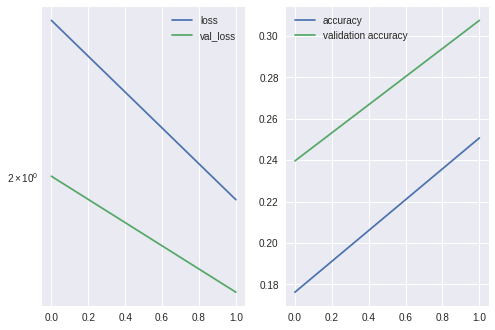


Epoch 00002: val_acc improved from 0.23960 to 0.30750, saving model to drive/app/modelweigh.h5


KeyboardInterrupt: ignored

In [6]:
##########################################################################################################################################
##################### DO NOT DELETE THIS!!!!!. IT PROVIDES THE LINK FOR ACCESSING TENSORBOARD. DO NOT DELETE THIS!!!!##################### 
!rm -rf ngrok-stable-linux-amd64.zip
!rm -rf ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!rm -rf log   #Delete this if you want to keep the logs of the old runs
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
##################### DO NOT DELETE THIS!!!!!. IT PROVIDES THE LINK FOR ACCESSING TENSORBOARD. DO NOT DELETE THIS!!!!#####################    
##########################################################################################################################################





from __future__ import print_function
import keras
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from IPython.display import clear_output
import sys
from keras.callbacks import TensorBoard
from keras import backend as K



K.clear_session() #used to delete the session in order to run the program multiple times


#############################
"""Global variables"""

#The path where the model will be saved (you may need to specify your own path). If wantToSaveModel and wantToLoadModel are not set then this will not affect the programm.
filepath=fullPath    

batch_size = 128
num_classes = 10
epochs = 1200
##############################



################################################################################################
"""Auxiliary functions for giving runtime information and plotting them during each epoch. Moreover, the callback to Tensorboard is provided here"""
"""Other auxiliary functions can be added here"""

# The events will be saved in ./log which is the folder that tensorboard uses to retrieve the data
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,                 
                         write_grads=True,
                         write_graph=True,                                  
                         batch_size=batch_size,
                         write_images=True,
                         )




class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()




class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()



# Saving the weights of the model
if wantToSaveModel:
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') # this callback will save the best model in the given path
    callbacksList=[plot_losses,plot,checkpoint,tbCallBack]
else:
    callbacksList=[plot_losses,plot,tbCallBack]

#########################################################################################################




##########################################################################################################
"""Setup data"""
(x_train, y_train), (x_test, y_test) =cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = np.reshape(x_train, (50000, 32*32*3))
x_test = np.reshape(x_test, (10000, 32*32*3))
############################################################################################################



#############################################################################################################
"""Setup model"""

model = Sequential()
model.add(Dense(units=3100, input_dim=32*32*3,activation="relu",name="dense_one"))
model.add(Dropout(0.20,name="dropout_one"))
model.add(Dense(units=200, input_dim=32*32*3,activation="relu",name="dense_two"))
model.add(Dropout(0.20,name="dropout_two"))
model.add(Dense(units=500, input_dim=32*32*3,activation="relu",name="dense_three"))
model.add(Dropout(0.20,name="dropout_three"))
model.add(Dense(units=500, input_dim=32*32*3,activation="relu",name="dense_four"))
model.add(Dropout(0.20,name="dropout_four"))
model.add(Dense(units=10, activation="softmax",name="dense_five"))

##############################################################################################################




###############################################################################################################
"""Run Model"""


# Loading the weights of the model
if wantToLoadModel:
      model.load_weights(filepath) #use it only when you want to load a model 

    
model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.RMSprop(lr=0.001 ), 
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

history=model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_split=0.2,
         callbacks=callbacksList,
         shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
#######################################################################################################




########################################################################################################
"""Plot graphs at end of the training process"""

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
########################################################################################################

In [0]:
USE THIS COMMAND TO OBTAIN THE PIDS OF THE PROCESSES THAT HAVE BEEN STARTED WHEN TENSORBOARD HAS BEEN INITIALIZED AND KILL THEM. 
IT WILL DELETE THE FILES THAT HAVE BEEN CREATED DURING THIS SESSION (USEFUL WHEN YOU WANT TO CLEAN THE DRIVE).
IF YOU GET "THE USAGE SCREEN" WHEN RUNNING KILL IT MEANS THAT ALL THE PROCESSES(OR SOME OF THOSE PROCESSES) CREATED BY TENSORBOARD HAVE BEEN ALREADY KILLED.

IT IS NOT MANDATORY TO EXECUTE THIS BUT IS WILL CLEAN YOUR DRIVE AND KILL THE PROCESSES THAT HAVE BEEN STARTED BY TENSORBOARD.

In [0]:
pid1 = !ps aux | grep tensorboard |  grep -v "grep" | grep "/usr/bin/python2 /usr/local/bin/tensorboard --logdir ./log --host 0.0.0.0 --port 6006" | awk '{print $2}' 
pid2 = !ps aux | grep ngrok | grep -v "grep" | grep "./ngrok http 6006" | awk '{print $2}'
!kill $(echo $pid1 | cut -d "[" -f2 | cut -d "]" -f1) 
!kill $(echo $pid2 | cut -d "[" -f2 | cut -d "]" -f1) 
!rm -rf ngrok-stable-linux-amd64.zip
!rm -rf ngrok
!rm -rf log
!rm -rf datalab/adc.json
!rm -rf Graph


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
